## Day 12
https://adventofcode.com/2025/day/12

In [1]:
import numpy as np
import time

def read_input_12(filename):
    with open(filename) as f:
        situation = f.read().split("\n\n")
        shapes = [np.array([[1 if c=="#" else 0 for c in r] for r in b.split("\n")[1:] ]) for b in situation[:-1]]
        regions = []
        for r in situation[-1].strip("\n").split("\n"):
            t = r.split(": ")
            size = tuple([int(i) for i in t[0].split("x")])
            tiles = [int(i) for i in t[1].split(" ")]
            regions.append((size, tiles))
    return shapes, regions

def all_rotations_and_flips(mat):
    transforms = []
    for k in range(4):
        transforms.append(np.rot90(mat, k))
    flipped = np.flip(mat, axis=1)
    for k in range(4):
        transforms.append(np.rot90(flipped, k))
    unique = []
    seen = set()
    for t in transforms:
        key = t.tobytes()
        if key not in seen:
            seen.add(key)
            unique.append(t)
    return unique

def precompute_placements(board_shape, shape_variants):
    nr, nc = board_shape
    placements = []
    for v_idx, variant in enumerate(shape_variants):
        vr, vc = variant.shape
        positions = [(r, c) for r in range(vr) for c in range(vc) if variant[r, c] == 1]
        for r in range(nr - vr + 1):
            for c in range(nc - vc + 1):
                board_positions = [(r + pr, c + pc) for pr, pc in positions]
                placements.append((v_idx, r, c, board_positions)) 
    return placements

def can_place(board, positions):
    """Check if all positions are free on the board."""
    return all(board[r, c] == 0 for r, c in positions)

def place(board, positions, value=1):
    """
    Place a shape on the board.
    Allow placing a unique value per shape (default value=1 keeps initial behavior,
    different values needed for drawing)
    """
    for r, c in positions:
        board[r, c] = value

def unplace(board, positions):
    """Remove a shape from the board."""
    for r, c in positions:
        board[r, c] = 0

START_TIME = None
TIME_LIMIT = 2.0 # seconds

def backtrack(board, shape_placements, remaining_shapes, time_cut=False, piece_id=1):
    """
    Backtracking with in-place board modifications
    - board: numpy array representing the current board state
    - shape_placements: dict mapping shape_idx -> list of precomputed placements
    - remaining_shapes: list of shape indices still to place
    - piece_id: unique ID assigned to each placed shape
    """
    if not remaining_shapes:
        return True, board

    if time_cut and time.time() - START_TIME > TIME_LIMIT:
        return False, None  # abort early
    
    # Pick next shape to place
    shape_idx = remaining_shapes[0]
    placements = shape_placements[shape_idx]
    
    # Try each placement
    for v_idx, r, c, positions in placements:
        if can_place(board, positions):
            # Place the shape using a UNIQUE incrementing value
            place(board, positions, value=piece_id)
            
            # Recurse with incremented piece_id
            solved, sol_board = backtrack(
                board,
                shape_placements,
                remaining_shapes[1:],
                time_cut,
                piece_id + 1
            )
            if solved:
                return True, sol_board
            
            # Backtrack: remove the shape
            unplace(board, positions)
    
    return False, None


def solve_region(region, shapes, check_region_size=True, time_limit=0):
    """Solve a region using backtracking"""

    global START_TIME, TIME_LIMIT
    time_cut = False
    if time_limit>0:
        TIME_LIMIT = time_limit
        START_TIME = time.time()
        time_cut = True

    size, tiles = region
    nr, nc = size
    
    # Build list of shape indices to place
    shape_list = []
    for i, count in enumerate(tiles):
        shape_list.extend([i] * count)

    # Check whether shape size is bigger than region area
    if check_region_size:
        if sum(sum(sum([shapes[i] for i in shape_list]))) > size[0]*size[1]:
            return False, None
    
    # Sort shapes by size (larger first)
    shape_sizes = [(i, np.sum(shapes[i])) for i in range(len(shapes))]
    shape_list.sort(key=lambda idx: shape_sizes[idx][1], reverse=True)
    
    # Precompute all transformations
    shape_variants = {}
    for shape_idx in set(shape_list):
        shape_variants[shape_idx] = all_rotations_and_flips(shapes[shape_idx])
    
    # Precompute all placements
    shape_placements = {}
    for shape_idx in set(shape_list):
        shape_placements[shape_idx] = precompute_placements((nr, nc), shape_variants[shape_idx])
    
    # Initialize empty board with np.int16
    board = np.zeros((nr, nc), dtype=np.int16)  # <-- Updated dtype
    
    solved, final_board = backtrack(board, shape_placements, shape_list, time_cut, piece_id=1)
    return solved, final_board

def solve12(filename, verbose=True, check_region_size=False, time_limit=0):

    start_time = time.time()    
    shapes, regions = read_input_12(filename)
    count = 0
    
    for i, region in enumerate(regions):
        region_start = time.time()
        solved, _ = solve_region(region, shapes, check_region_size, time_limit)
        region_time = time.time() - region_start
        
        if verbose: 
            print(f"Region {i+1}: {region[0]} with tiles {region[1]} -> {solved} (took {region_time:.3f}s)")
        else:
            print(f"Region {i+1} / {len(regions)}",end="\r")
        if solved:
            count += 1
    
    print(f"\nRegions that can fit selected shapes: {count}")
    total_time = time.time() - start_time        
    print(f"Total execution time: {total_time:.3f}s")
    
    return count

In [2]:
solve12("examples/example12.txt", verbose=True)

Region 1: (4, 4) with tiles [0, 0, 0, 0, 2, 0] -> True (took 0.000s)
Region 2: (12, 5) with tiles [1, 0, 1, 0, 2, 2] -> True (took 0.001s)
Region 3: (12, 5) with tiles [1, 0, 1, 0, 3, 2] -> False (took 98.586s)

Regions that can fit selected shapes: 2
Total execution time: 98.588s


2

### Quick and dirty solution

If a solution exists, it is found rather quickly. On the other hand, **if a solution does not exist, backtracking takes a long time to explore the full phase space (and there are 1000 large regions with lots of shapes to be tested in the full input!).** The correct solution to this would be to implement pruning strategies, but before attempting it **I will try to simply top the solving procedure that takes too long to converge ;-)**. 

This is potentially dangerous, since it does not guarantee that a solution could ultimately be found in longer searches...

In [3]:
solve12("examples/example12.txt", verbose=True, time_limit=1)

Region 1: (4, 4) with tiles [0, 0, 0, 0, 2, 0] -> True (took 0.000s)
Region 2: (12, 5) with tiles [1, 0, 1, 0, 2, 2] -> True (took 0.001s)
Region 3: (12, 5) with tiles [1, 0, 1, 0, 3, 2] -> False (took 1.000s)

Regions that can fit selected shapes: 2
Total execution time: 1.002s


2

In [ ]:
solve12("AOC2025inputs/input12.txt", verbose=False, time_limit=1)

**... and the dirty approach works!!! ;-)**

### Pruning strategies

The simplest pruning strategy I can try is to check whether **there's enough space in the region to contain all shapes**. Not very effective for the example...

In [ ]:
solve12("examples/example12.txt", verbose=True, check_region_size=True)

In [ ]:
solve12("AOC2025inputs/input12.txt", verbose=False, check_region_size=True)

**... but it works great for the input: all regions with no solution seem to be such becouse of lack of space, not of possible combinations! Damn, Eric! ;-)**

### Ok, it was a trap...

Solvable boards in full input are *simply those with enough space to accomodate the tiles*, and that's it...

In [13]:
def has_enough_space(region, shapes):
    size, tiles = region  
    shape_list = []
    for i, count in enumerate(tiles):
        shape_list.extend([i] * count)
    return sum(sum(sum([shapes[i] for i in shape_list]))) <= size[0]*size[1]

shapes, regions = read_input_12("AOC2025inputs/input12.txt")
print(sum([is_region_solvable_by_space(region, shapes) for region in regions]))

575


### Plots!

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def shuffle_piece_ids(board):
    """
    Randomly remap piece IDs on a solved board to improve color contrast.
    The board is assumed to contain:
    - 0 for empty tiles
    - positive integers for pieces
    """
    flat = board.flatten()
    
    # Extract all unique piece IDs > 0
    piece_ids = np.unique(flat)
    piece_ids = piece_ids[piece_ids > 0]

    # Create a shuffled version
    shuffled_ids = piece_ids.copy()
    np.random.shuffle(shuffled_ids)

    # Build a mapping old_id -> new_id
    mapping = {old: new for old, new in zip(piece_ids, shuffled_ids)}

    # Create a new board to return
    new_board = board.copy()
    for old, new in mapping.items():
        new_board[board == old] = new

    return new_board

def make_piece_colormap(num_pieces):
    """
    Create a colormap where:
    - 0 = black (empty cell)
    - 1..num_pieces = distinct vivid colors
    """
    # Base high-contrast palette
    base_colors = [
        (1.0, 0.0, 0.0),    # red
        (0.0, 1.0, 0.0),    # green
        (0.0, 0.0, 1.0),    # blue
        (1.0, 0.5, 0.0),    # orange
        (0.6, 0.0, 0.8),    # purple
        (1.0, 1.0, 0.0),    # yellow
        (0.0, 0.7, 0.7),    # teal
        (1.0, 0.0, 1.0),    # magenta
        (0.5, 1.0, 0.0),    # lime
        (1.0, 0.6, 0.7),    # pink
        (0.0, 1.0, 1.0),    # cyan
        (0.5, 0.3, 0.1),    # brown
    ]

    # If more colors are needed, repeat but with order shuffled
    colors_needed = num_pieces
    palette = []
    while len(palette) < colors_needed:
        block = base_colors.copy()
        np.random.shuffle(block)
        palette.extend(block)

    palette = palette[:colors_needed]
    full_colors = [(0, 0, 0)] + palette # Insert black for value 0 (empty)
    return ListedColormap(full_colors)
    

def plot_solved_boards_grid(filename, rows=2, cols=3, max_boards=12, savefile=None ):
    shapes, regions = read_input_12(filename)
    total_slots = rows * cols

    # Solve boards
    boards_to_plot = []
    for region in regions:
        if len(boards_to_plot) >= max_boards:
            break
        solved, board = solve_region(region, shapes, check_region_size=True, time_limit=1)
        if solved:
            boards_to_plot.append((region, shuffle_piece_ids(board)))
            print(f"{len(boards_to_plot)} boards solved",end="\r")
    if not boards_to_plot:
        return

    # Plot board grid
    print()
    n_plots = min(len(boards_to_plot), total_slots)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(rows, cols)

    ip=1
    for idx in range(rows * cols):
        ax = axes[idx // cols, idx % cols]

        if idx < n_plots:
            region, board = boards_to_plot[idx]

            num_pieces = np.max(board)
            cmap = make_piece_colormap(num_pieces)

            ax.imshow(board, cmap=cmap, vmin=0, vmax=num_pieces)
            ax.set_title(f"{region[0]}, tiles {region[1]}", fontsize=9)
            ax.axis("off")
            print(f"{ip} boards plotted",end="\r")
            ip+=1
        else:
            ax.axis("off")

    plt.tight_layout()

    if savefile:
        plt.savefig(savefile, dpi=300, bbox_inches="tight")

    plt.show()


2 boards solved
2 boards plotted

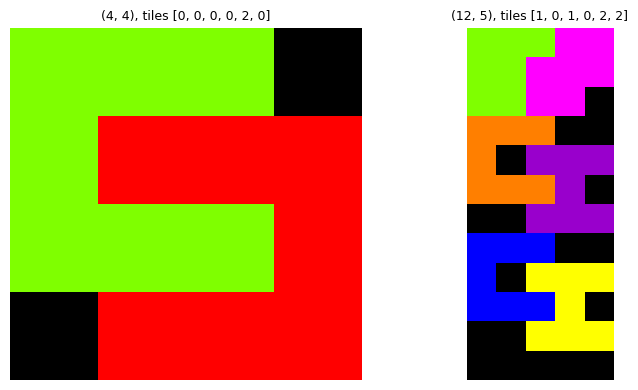

In [35]:
plot_solved_boards_grid("examples/example12.txt",1,2,2,savefile="visualisation/day12_1.png")

In [36]:
plot_solved_boards_grid("AOC2025inputs/input12.txt",60,10,575,savefile="visualisation/day12_2.png")

575 boards solved
575 boards plotted